<a href="https://colab.research.google.com/github/rubygitflow/Glossary-extraction/blob/main/University_of_Artificial_Intelligence_Glossary_extraction_Graduate_work_2020_v_0_6_12_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The research project — Glossary extraction

# **Service data**

In [ ]:
!nvidia-smi

Wed Dec  2 16:51:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Ссылки на файлы данных:

База_словарей_train_6.docx : https://drive.google.com/file/d/13QKXApDf8q8R_BYviX1J80BCJXUOlZUw/view?usp=sharing

База_словарей_test_6.docx : https://drive.google.com/file/d/19a1rOu6NuAb-Y_HrHhN7Ssg_ZvxTXHhH/view?usp=sharing

База_словарей_train_6.xml : https://drive.google.com/file/d/16lNQFww1QyYRxr8S4OsA2THypqxLQOra/view?usp=sharing

База_словарей_test_6.xml : https://drive.google.com/file/d/1-9fG7sdiZnjkarvitPYgX9PFt95eErPi/view?usp=sharing


In [ ]:
color_meaning = {'00ffff':'термин', 'ffff00':'связка', '00ff00':'определение', 'd3d3d3':'расшифровка', 
                 'ff00ff':'дубль-термин', 'ff0000':'дубль-связка', '808000':'дубль-определение', '0000ff':'дубль-расшифровка',
                 'cyan':'термин','yellow':'связка','green':'определение', 'lightgray':'расшифровка',	                 
                 'magenta':'дубль-термин', 'red':'дубль-связка','darkyellow':'дубль-определение', 'blue':'дубль-расшифровка'}

                 #создаем словарь соответствий цвет-значение   

In [ ]:
color_dic = {'термин':0,'связка':1,'определение':2,'расшифровка':3,
			       'дубль-термин':4,'дубль-связка':5,'дубль-определение':6,'дубль-расшифровка':7}
dic_color = {value:key for key, value in color_dic.items()}

zero_symbol = 'o'

colors_count = len(color_dic) + 1 # количество уникальных тегов (не забываем про тег отсутствия класса для разметки)

skip_amount = colors_count  # кол-во пропускаемых строк под легенду при считывании данных (здесь учитывается, что есть пусая строка, в списке тегов последнее значение используется под отсутствующий класс для разметки)

In [ ]:
colors_count

9

In [ ]:
# названия необходимых тегов для извлекаемых категорий
r = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}r'
rpr = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}rPr'
t = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t'
shd = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}shd'
fill = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}fill'
highlight = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}highlight'
val = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val'

In [ ]:
''' 
  Словарь для цветовой разметки разобранного текста
'''
class color:
  GREY    = '\33[90m'
  RED2    = '\33[91m'
  GREEN2  = '\33[92m'
  YELLOW2 = '\33[93m'
  BLUE2   = '\33[94m'
  VIOLET2 = '\33[95m'
  LI_CYAN = '\33[96m'
  WHITE2  = '\33[97m'

  BLACK  = '\33[30m'
  RED    = '\33[31m'
  GREEN  = '\33[32m'
  YELLOW = '\33[33m'
  BLUE   = '\33[34m'
  VIOLET = '\33[35m'
  CYAN   = '\33[36m'
  WHITE  = '\33[37m'

  GREYBG    = '\33[100m'
  REDBG2    = '\33[101m'
  GREENBG2  = '\33[102m'
  YELLOWBG2 = '\33[103m'
  BLUEBG2   = '\33[104m'
  VIOLETBG2 = '\33[105m'
  LI_CYANBG = '\33[106m'
  WHITEBG2  = '\33[107m'

  BLACKBG  = '\33[40m'
  REDBG    = '\33[41m'
  GREENBG  = '\33[42m'
  YELLOWBG = '\33[43m'
  BLUEBG   = '\33[44m'
  VIOLETBG = '\33[45m'
  CYANBG   = '\33[46m'
  WHITEBG  = '\33[47m'


  BOLD 		  = '\33[1m'
  ITALIC 	  = '\33[3m'
  UNDERLINE = '\33[4m'

  BLINK    = '\33[5m'
  BLINK2   = '\33[6m'
  SELECTED = '\33[7m'
  END 		 = '\33[0m'
  
dic_colored_items = {0:color.LI_CYANBG+color.BLACK, 1:color.YELLOWBG2+color.BLACK, 2:color.GREENBG2+color.BLACK, 3:color.WHITEBG+color.BLACK,
			               4:color.VIOLETBG2+color.WHITE2, 5:color.REDBG2+color.WHITE2, 6:color.YELLOWBG+color.BLACK, 7:color.BLUEBG+color.WHITE2}

## Connecting libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate, Activation, MaxPooling1D, Conv1D  # Импортируем стандартные слои keras
from tensorflow.keras.layers import Dropout, BatchNormalization, Conv2DTranspose, Lambda, LSTM, GRU, Bidirectional, GlobalMaxPool1D # Импортируем стандартные слои keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from tensorflow.keras.metrics import AUC

from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import collections
%matplotlib inline
import numpy as np # Импортируем библиотеку numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report # статистика точности предсказания по классам
import random
import datetime
import time

import xml.etree.ElementTree as ET
import re

import os # Импортируем библиотеку os для работы с фаловой системой
from google.colab import files # Импортируем Модуль files для работы с файлами
from google.colab import drive # Подключаем гугл-диск

from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Library of Functions

In [ ]:
'''
  Сервиная функция:
  Загрузка выборки заданного количества фраз из файла 
'''
def load_xml(filename, paragraphs_amount):
    test_tree = ET.parse(filename)

    test_root = test_tree.getroot()
    test_body = test_root[0]
    test_row_count = paragraphs_amount + skip_amount
    return list(iter(test_body))[:test_row_count]

In [ ]:
'''
  Сервиная функция:
  Вставка пробела в заданной позиции в строке
'''
def insert_space(text, index):
  return text[:index] + ' ' + text[index:]

In [ ]:
'''
  Основная функция для подготовки обучающей выборки.
  Создаём параллельные массивы с текстом — paragraphs,
  категориями лексем — tags
  и классификацией предложений — semantics
'''
def pars_xml(ps):
    # Массивы данных по параграфам
    paragraphs = []
    tags = []
    semantics = []
    exception_amount = 0
    exception_array = []
    # Массив фактических цветов в файле исходных данных
    colors = set() # все цвета в документе
    # длина массива лексем в параграфе
    max_paragraph_len = 0  # Максимальная длина предложения
    max_paragraph_len_ind = -1  # Индекс предложения с максимальной длиной

    for i, paragraph in enumerate(ps): # проходим по всем абзацам
        z_item = [0] # массив семантических индикаторов -  наличие определительной струткуры первого и второго уровня
        if i > colors_count - 1:     # пропускаем легенду для цветовой разметки    
            phrases_list = paragraph.findall(r) # находим все фразы (часть новости)
            p_words = [] # список сущностей в абзаце
            tags_w = [] # список семантических цветов для слов в абзаце

            last_ind = len(phrases_list)-1
            for ind, phrase in enumerate(phrases_list): # проходим по всем фразам в абзаце
                words = [] # список сущностей во фразе
                y_list = [] # категории для сущностей во фразе

                try:
                  text = phrase.find(t).text # получаем текст, содержащийся во фразе

                  # if i>1300:
                  #   print(i,last_ind, text)

                  # 1) выделяем пробелом точку (воскл.зн., вопр.зн., двоеточние) в конце предложения
                  text_comma = text.strip()
                  len_text = len(text_comma)-1
                  if ind==last_ind and len_text>0: 
                    if text_comma[len_text] in ['.', ':', '!', '?']:
                      text_comma = insert_space(text_comma, len_text)
                    
                  # 2) выделяем пробелами символы: , { } ( ) [ ] ; « » „ “ "
                  text_comma = text_comma.replace(',', ' , ')
                  text_comma = text_comma.replace('(', ' ( ')
                  text_comma = text_comma.replace(')', ' ) ')
                  text_comma = text_comma.replace('[', ' [ ')
                  text_comma = text_comma.replace(']', ' ] ')
                  text_comma = text_comma.replace('{', ' { ')
                  text_comma = text_comma.replace('}', ' } ')
                  text_comma = text_comma.replace('"', ' " ')
                  text_comma = text_comma.replace('„', ' „ ')
                  text_comma = text_comma.replace('“', ' “ ')
                  text_comma = text_comma.replace('«', ' « ')
                  text_comma = text_comma.replace('»', ' » ')
                  text_comma = text_comma.replace(';', ' ; ')


                  # 3) заменяем все виды пробелов одиночным пробелом #32  
                  text_comma = text_comma.replace('\xa0', '')
                  text_comma = text_comma.replace('\x301', '')
                  text_comma = text_comma.replace('\u0301', '')
                  text_comma = text_comma.replace('\ufeff', '')
                  text_comma = text_comma.replace('  ', ' ')
                  text_comma = text_comma.replace('  ', ' ')
                  text_comma = text_comma.strip()      

                  # 4) выделяем левым пробелом двоеточие (:) при одновременном выполнении условий: 
                  # после двух буквенных символов в любом алфавите и перед правым пробелом. 
                  # https://habr.com/ru/post/349860/
                  text_comma = re.sub(r'(\w\w)(:)(\s)',  r'\1 \2\3', text_comma)
                  text_comma = re.sub(r'(\w\w)(:)$',  r'\1 \2', text_comma)


                  if (len(text_comma)>0):
                    text_comma = text_comma.lower()

                    style = phrase.find(rpr) # получаем стили фразы
                    
                    if style.find(shd) is not None: # если размечали через заливку
                        color = style.find(shd).attrib[fill] # получаем значение цвета заливки
                    elif style.find(highlight) is not None: # если размечали через хайлайт
                        color = style.find(highlight).attrib[val] # получаем значение цвета хайлайта
                    else:
                        color = 'white' # иных вариантов выделения в word нет, значит эта фраза не выделена (белый цвет)
                    color = color.lower() # переводим строковое значение цвета в нижний регистр
                    meaning = color_meaning[color] if color in color_meaning else '' # если есть цвет в словаре цвет-значение, то получаем значение. в противном случае у фразы значение не было выделено
                    
                    colors.add(color) # добавляем цвет в словарь всех встреченных цветов, если нужно проанализировать их
                    
                    words = text_comma.split()
                    k = len(words)
                    if meaning in color_dic: # если во фразе присутствует какая-то выделяемая сущность
                      z_item = [1] # отмечаем фразу с понятийной структурой
                      for j in range(k):
                        y_list.append(meaning) # получаем индекс позиции, соответствующей какой-то семантической(смысловой) окраске и устанавливаем по этому индексу абсолютное значение категории
                    else:
                      for j in range(k):
                        y_list.append(zero_symbol)
            
                    p_words += words  # список сущностей в параграфе
                    tags_w += y_list # список семантических цветов для слов в параграфе

                except Exception:
                  exception_amount += 1
                  exception_array.append(i)

            # print(i, p_words)
            if p_words and len(p_words)>3: # количество слов в предложении позволяет иметь в себе определительную структуру 
                                           # как минимум из 3-х слов и завершающего знака препинания
              paragraphs.append(p_words)
              tags.append(tags_w)
              semantics.append(z_item) # записываем семантику
              
            if len(p_words) >= max_paragraph_len: 
              max_paragraph_len = len(p_words)
              max_paragraph_len_ind = i - skip_amount

        if i%100==0:
            print('line',i)

    return     paragraphs, tags, colors, max_paragraph_len, max_paragraph_len_ind, exception_array, semantics

In [ ]:
'''
  Графическая функция:
  Подсчёт и вывод на печать статистики о содержании категорий определительных структур в размеченных текстах
'''
def class_stat(paragraphs, tags, ext_print = False):
  classes = np.zeros((colors_count))
  len_tags = len(tags)
  print('Длина размеченной выборки:', len_tags)
  if ext_print:
    print("\nПеречень фраз со 100% разметкой:")
  for i, elem in enumerate(tags):
    if zero_symbol in elem:
      if len(set(elem))==1:
        classes[0] += 1
    else:
      if ext_print:
        print("paragraphs[{}]".format(i), '=',paragraphs[i])
        print("tags[{}]".format(i), '=',tags[i])
        print(" ")
    for item in list(color_dic.keys()):
      if item in elem:
        real_index = int(color_dic[item]) + 1
        classes[real_index] += 1
  print("\nСтатистика по классам")
  for i in range(len(classes)):
    if i==0:
      print(f'Фраз без определительных структур: {classes[0]} - {round(classes[0]*100./len_tags,2)}%')
    else:
      key=list(color_dic.keys())[list(color_dic.values()).index(i-1)] # ключ по значению
      print(f'Фраз с категорией {key}: {classes[i]} - {round(classes[i]*100./len_tags,2)}%')

In [ ]:
'''
  Графическая функция:
  Построение статистических графиков по входным данным.
'''
def draw_paragraphs_stat(paragraphs):
  # https://pyprog.pro/mpl/mpl_bar.html
  counter = []
  for elem in paragraphs:
    counter.append(len(elem))

  plt.figure(figsize=(27, 5))
  plt.grid(True)
  plt.bar(range(len(paragraphs)), counter)
  plt.suptitle('Фактическое распределение длин абзацев (в лексемах)')
  plt.show()

  dic_counter = collections.Counter(counter)
  print('Collections',dic_counter)

  plt.figure(figsize=(15, 5))
  plt.grid(True)
  plt.bar(dic_counter.keys(), dic_counter.values())
  plt.suptitle('Статистика кол-ва абзацев по их длинам')
  plt.show()

  return counter, dic_counter

In [ ]:
'''
  Сервисная функция:
  Сделать разметку текста цветом
'''
def tokens_to_text(x_arr, y_arr, max_len = 0):
  res = '' 
  str_len = 0
  def add_col(col, txt):
    nonlocal res, str_len
    if max_len > 0:
      next_len = len(txt)
      if str_len + next_len > max_len:
        res = res + col + '\n ' + txt
        str_len = next_len + 1
      else:
        res = res + col + ' ' + txt
        str_len += next_len + 1
    else:
      res = res + col + ' ' + txt

  for i, el in enumerate(x_arr):
    if el==0:
      break
    col_ind = y_arr[i].argmax() + 1
    add_col(tag_tokenizer_dic_color[col_ind], tokenizer.index_word[el])

  return res + color.END

# **Reading input data**

## Reading and verifying data (XML parsing). 

### Training sample

In [ ]:
paragraphs_amount = 2860
ps_train = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_train_6.xml', paragraphs_amount)

In [ ]:
paragraphs_train, tags_train, train_colors, max_paragraph_len, max_paragraph_len_ind, exception_array, semantics_train  = pars_xml(ps_train)
paragraphs_amount = len(paragraphs_train)  # обновляем длину массива на случай наличия в исходной базе пустых строк
paragraphs_amount, exception_array # контрольный вывод на размера принятых данных и массива индексов пустых строк

line 0
line 100
line 200
line 300
line 400
line 500
line 600
line 700
line 800
line 900
line 1000
line 1100
line 1200
line 1300
line 1400
line 1500
line 1600
line 1700
line 1800
line 1900
line 2000
line 2100
line 2200
line 2300
line 2400
line 2500
line 2600
line 2700
line 2800


(2860, [])

In [ ]:
# Визуальный контроль правильности разбора файла
for i, elem in enumerate(paragraphs_train):
  print(i+1, elem)

1 ['декларативное', 'программирование', '—', 'парадигма', 'программирования', ',', 'в', 'которой', 'задаётся', 'спецификация', 'решения', 'задачи', ',', 'то', 'есть', 'описывается', ',', 'что', 'представляет', 'собой', 'проблема', 'и', 'ожидаемый', 'результат', '.']
2 ['императивное', 'программирование', '—', 'это', 'парадигма', 'программирования', '(', 'стиль', 'написания', 'исходного', 'кода', 'компьютерной', 'программы', ')', ',', 'для', 'которой', 'характерно', 'следующее', ':', 'в', 'исходном', 'коде', 'программы', 'записываются', 'инструкции', '(', 'команды', ')', ';', 'инструкции', 'должны', 'выполняться', 'последовательно', ';', 'данные', ',', 'получаемые', 'при', 'выполнении', 'предыдущих', 'инструкций', ',', 'могут', 'читаться', 'из', 'памяти', 'последующими', 'инструкциями', ';', 'данные', ',', 'полученные', 'при', 'выполнении', 'инструкции', ',', 'могут', 'записываться', 'в', 'память', '.']
3 ['автоматический', 'словарь', '—', 'это', 'словарь', 'в', 'специальном', 'машинном

In [ ]:
# sem_counter = collections.Counter(semantics_train)
# sem_counter
train_yes = 0
train_no = 0
for elem in semantics_train:
  if elem[0]==1:
    train_yes += 1
  else:
    train_no += 1
print(f"train: yes={train_yes}, no={train_no}")

train: yes=1543, no=1317


In [ ]:
if len(train_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
train_colors # выведем все цвета, которые мы встретили

{'blue',
 'cyan',
 'darkyellow',
 'green',
 'lightgray',
 'magenta',
 'red',
 'white',
 'yellow'}

In [ ]:
print(len(paragraphs_train))
print(len(tags_train))

print('Максимальная длина предложения — max_paragraph_len =',max_paragraph_len)
print('Индекс предложения с максимальной длиной — max_paragraph_len_ind =',max_paragraph_len_ind)

2860
2860
Максимальная длина предложения — max_paragraph_len = 120
Индекс предложения с максимальной длиной — max_paragraph_len_ind = 1610


In [ ]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_paragraph_len = 128

In [ ]:
train_paragraphs_len = len(paragraphs_train)
print('Длина обучающей выборки:', train_paragraphs_len)

Длина обучающей выборки: 2860


**Извлекаем статистику по абзацам**

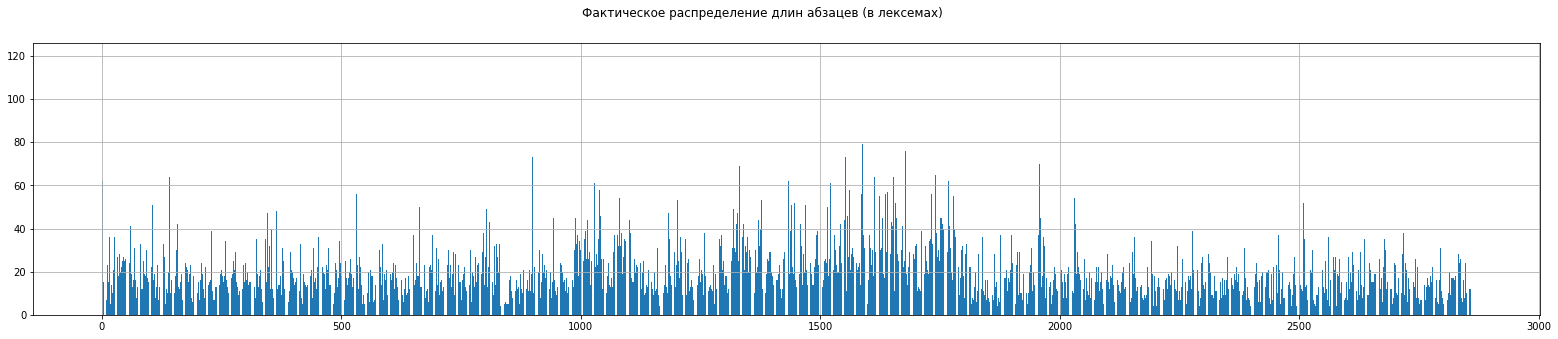

Collections Counter({13: 147, 12: 139, 15: 131, 19: 128, 14: 127, 11: 127, 10: 117, 16: 117, 9: 108, 8: 103, 18: 101, 17: 101, 20: 99, 7: 92, 22: 87, 21: 81, 24: 70, 23: 69, 26: 66, 25: 64, 5: 62, 27: 60, 6: 57, 31: 49, 29: 48, 30: 47, 28: 45, 4: 33, 32: 31, 33: 30, 37: 27, 35: 27, 36: 23, 39: 19, 34: 19, 38: 18, 42: 16, 40: 15, 45: 15, 41: 14, 43: 9, 51: 8, 47: 8, 56: 8, 44: 8, 52: 7, 48: 7, 49: 7, 46: 7, 62: 6, 50: 6, 64: 4, 53: 4, 58: 4, 57: 4, 73: 3, 55: 3, 61: 2, 54: 2, 69: 2, 72: 2, 59: 2, 65: 2, 63: 1, 60: 1, 103: 1, 75: 1, 85: 1, 83: 1, 77: 1, 79: 1, 120: 1, 76: 1, 67: 1, 80: 1, 99: 1, 88: 1, 104: 1, 70: 1})


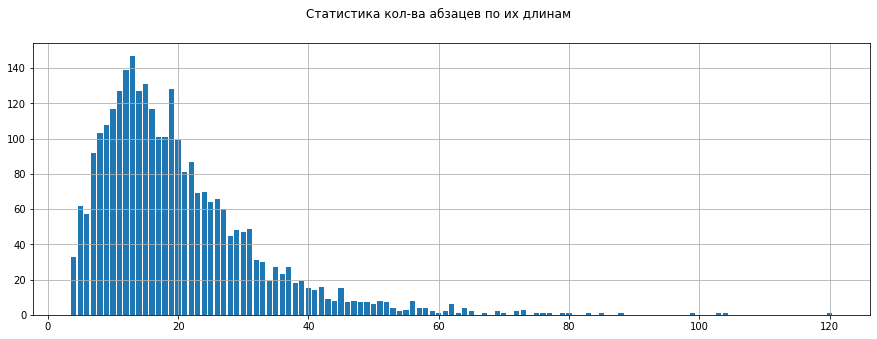

In [ ]:
train_counter, train_count = draw_paragraphs_stat(paragraphs_train)

**Во скольких фразах встречается тот или  иной класс**

In [ ]:
class_stat(paragraphs_train, tags_train)

Длина размеченной выборки: 2860

Статистика по классам
Фраз без определительных структур: 1317.0 - 46.05%
Фраз с категорией термин: 1529.0 - 53.46%
Фраз с категорией связка: 1494.0 - 52.24%
Фраз с категорией определение: 1511.0 - 52.83%
Фраз с категорией расшифровка: 728.0 - 25.45%
Фраз с категорией дубль-термин: 364.0 - 12.73%
Фраз с категорией дубль-связка: 264.0 - 9.23%
Фраз с категорией дубль-определение: 245.0 - 8.57%
Фраз с категорией дубль-расшифровка: 57.0 - 1.99%


### Testing sample

In [ ]:
test_paragraphs_amount = 715
ps_test = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_test_6.xml', test_paragraphs_amount)
print(len(ps_test))

724


In [ ]:
paragraphs_test, tags_test, test_colors, max_test_paragraph_len, max_test_paragraph_len_ind, test_exception_array, semantics_test  = pars_xml(ps_test)
test_paragraphs_amount = len(paragraphs_test)  # обновляем длину массива на случай наличия в исходной базе пустых строк
test_paragraphs_amount, test_exception_array # контрольный вывод на размера принятых данных и массива индексов пустых строк

line 0
line 100
line 200
line 300
line 400
line 500
line 600
line 700


(715, [])

In [ ]:
# Визуальный контроль правильности разбора файла
for i, elem in enumerate(paragraphs_test):
  print(i+1, elem)

1 ['удобный', 'поиск', '—', 'возможность', 'использования', 'эффективной', 'системы', 'поиска', '(', 'полнотекстовый', 'поиск', ',', 'одновременный', 'поиск', 'в', 'нескольких', 'словарях', ',', 'высокая', 'скорость', 'поиска', ')', '[', '26', ']', '.']
2 ['синтаксический', 'анализатор', '(', 'жарг.', 'парсер', '←', 'англ.', 'parser', ')', '—', 'это', 'программа', 'или', 'часть', 'программы', ',', 'выполняющая', 'синтаксический', 'анализ', '.']
3 ['свойство', '—', 'необходимое', 'условие', 'принадлежности', 'классу', '.']
4 ['парадигма', 'программирования', 'как', 'исходная', 'концептуальная', 'схема', 'постановки', 'проблем', 'и', 'их', 'решения', 'является', 'инструментом', 'грамматического', 'описания', 'фактов', ',', 'событий', ',', 'явлений', 'и', 'процессов', ',', 'возможно', ',', 'не', 'существующих', 'одновременно', ',', 'но', 'интуитивно', 'объединяемых', 'в', 'общее', 'понятие', '.']
5 ['ветвление', '—', 'однократное', 'выполнение', 'одной', 'из', 'двух', 'или', 'более', 'опе

In [ ]:
# sem_test_counter = collections.Counter(semantics_test)
# sem_test_counter
test_yes = 0
test_no = 0
for elem in semantics_test:
  if elem[0]==1:
    test_yes += 1
  else:
    test_no += 1
print(f"train: yes={test_yes}, no={test_no}")

train: yes=405, no=310


In [ ]:
if len(test_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
test_colors # выведем все цвета, которые мы встретили

{'blue',
 'cyan',
 'darkyellow',
 'green',
 'lightgray',
 'magenta',
 'red',
 'white',
 'yellow'}

In [ ]:
print(len(paragraphs_test))
print(len(tags_test))

print('Максимальная длина предложения — max_test_paragraph_len =',max_test_paragraph_len)
print('Индекс предложения с максимальной длиной — max_test_paragraph_len_ind =',max_test_paragraph_len_ind)

715
715
Максимальная длина предложения — max_test_paragraph_len = 64
Индекс предложения с максимальной длиной — max_test_paragraph_len_ind = 60


In [ ]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_test_paragraph_len = max_paragraph_len

**Извлекаем статистику по абзацам**

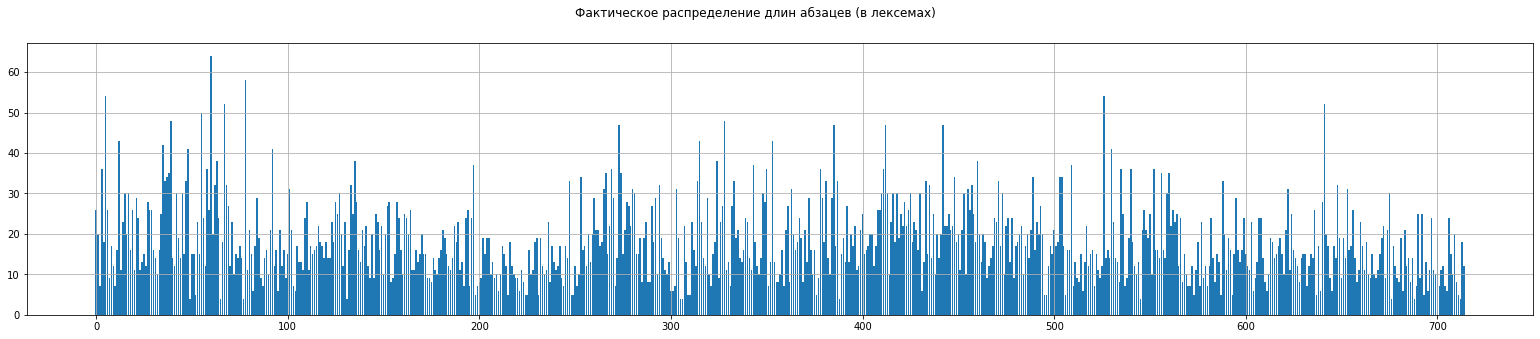

Collections Counter({15: 40, 14: 40, 12: 37, 16: 37, 10: 34, 17: 32, 11: 31, 9: 29, 13: 29, 20: 27, 7: 26, 18: 26, 19: 25, 21: 23, 23: 22, 8: 22, 24: 20, 5: 20, 22: 18, 30: 17, 26: 16, 25: 16, 6: 16, 4: 11, 29: 10, 28: 10, 33: 10, 36: 9, 27: 9, 31: 8, 32: 7, 34: 6, 35: 5, 38: 4, 47: 4, 43: 3, 41: 3, 37: 3, 54: 2, 48: 2, 52: 2, 42: 1, 50: 1, 64: 1, 58: 1})


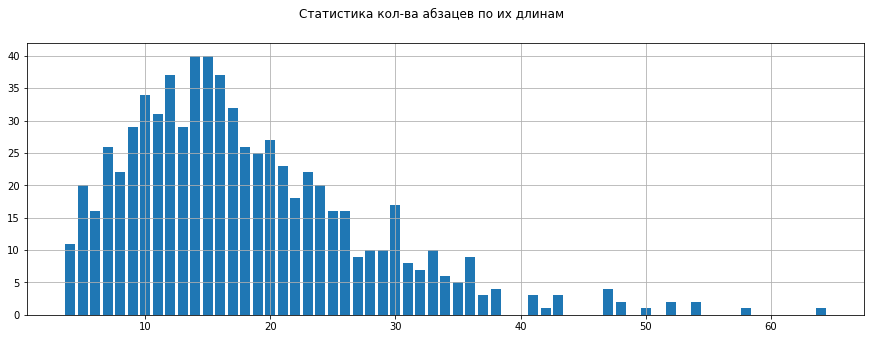

In [ ]:
test_counter, test_count = draw_paragraphs_stat(paragraphs_test)

**Во скольких фразах встречается тот или  иной класс**

In [ ]:
class_stat(paragraphs_test, tags_test)

Длина размеченной выборки: 715

Статистика по классам
Фраз без определительных структур: 310.0 - 43.36%
Фраз с категорией термин: 405.0 - 56.64%
Фраз с категорией связка: 401.0 - 56.08%
Фраз с категорией определение: 404.0 - 56.5%
Фраз с категорией расшифровка: 210.0 - 29.37%
Фраз с категорией дубль-термин: 95.0 - 13.29%
Фраз с категорией дубль-связка: 46.0 - 6.43%
Фраз с категорией дубль-определение: 52.0 - 7.27%
Фраз с категорией дубль-расшифровка: 7.0 - 0.98%


# **Step 1. Text Classification**

## Preparing a dataset

Объединим обучающий и тестовый массивы, чтобы воспользоваться общим токенизатором.

In [ ]:
full_paragraphs = paragraphs_train + paragraphs_test
full_semantics = semantics_train + semantics_test
print(len(full_paragraphs))
print(len(full_semantics))

3575
3575


In [ ]:
full_paragraphs_together = [' '.join(sequence) for sequence in full_paragraphs]

In [ ]:
full_paragraphs_together[max_paragraph_len_ind]

'существительное называет предметы в широком смысле слова ; это — названия вещей ( стол , стена , окно , ножницы , сани ) , лиц ( ребёнок , девочка , юноша , человек ) , веществ ( крупа , сахар , сливки , кислота ) , живых существ и организмов ( кошка , собака , ворона , дятел , окунь , щука , бактерия , вирус , микроб ) , фактов , событий , явлений ( пожар , спектакль , беседа , каникулы , радость ) , географические положения ( россия , байкал , оренбург , европа ) , а также качеств , свойств , действий , состояний ( доброта , синева , бег , решение , толкотня ) .'

In [ ]:
print(full_semantics[-20:])

[[0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]


In [ ]:
full_semantics[max_paragraph_len_ind]

[1]

In [ ]:
num_words = 15000
sent_len = max_paragraph_len 
tokenizer = Tokenizer(num_words, filters=' \t\n', oov_token='<UNK>')

In [ ]:
tokenizer.fit_on_texts(full_paragraphs_together)

In [ ]:
# реальная длина словаря. Сравниваем со значением num_words
len(tokenizer.index_word)

14552

**Проверка входящих и исходящих массивов на соответствие их размерностей** 

(для выявления факта порчи данных функцией Tokenizer)

In [ ]:
X = tokenizer.texts_to_sequences(full_paragraphs_together)

In [ ]:
Y = np.array(full_semantics)

In [ ]:
len(X)==len(Y)

True

In [ ]:
print(Y)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [ ]:
print(X)

[[5656, 198, 6, 310, 50, 2, 4, 110, 1511, 3462, 281, 329, 2, 34, 47, 5657, 2, 21, 227, 122, 595, 5, 2482, 344, 3], [5658, 198, 6, 14, 310, 50, 8, 1512, 596, 597, 86, 1513, 107, 7, 2, 9, 110, 5659, 1514, 11, 4, 2483, 649, 107, 1891, 427, 8, 724, 7, 25, 427, 140, 1251, 2484, 25, 141, 2, 5660, 38, 1892, 1515, 1061, 2, 72, 5661, 26, 399, 5662, 5663, 25, 141, 2, 5664, 38, 1892, 427, 2, 72, 5665, 4, 2485, 3], [5666, 213, 6, 14, 213, 4, 5667, 5668, 904, 2, 1252, 9, 372, 13, 3463, 1516, 15, 1513, 1517, 214, 428, 3], [2486, 429, 2, 1062, 2487, 1063, 5669, 5, 2487, 1063, 9, 330, 214, 428, 3], [5670, 6, 14, 174, 1064, 90, 5671, 58, 2488, 8, 725, 792, 7], [3464, 213, 6, 14, 269, 1893, 2, 905, 1253, 539, 5672, 193, 2, 5673, 4, 166, 311, 2, 1065, 15, 5674, 2, 3465, 9, 3466, 4, 399, 3463, 5, 5675, 3467, 5676, 214, 5, 5677, 19, 2489, 20, 3], [400, 3464, 213, 67, 61, 3468, 9, 1518, 793, 5678, 1894, 2, 3469, 4, 3470, 166, 5, 3471, 598, 91, 3472, 2, 3473, 15, 1254, 104, 3], [5679, 6, 3474, 1255, 142, 2, 

**Выравнивание массивов до максимального размера абзаца**

In [ ]:
X = pad_sequences(X, sent_len, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [ ]:
X.shape

(3575, 128)

In [ ]:
Y.shape

(3575, 1)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=train_paragraphs_len, shuffle=False) # Не перемешиваем данные и берём целую часть на тренировочную выборку

### Total for training and testing samples we have:

In [ ]:
print('Xtrain.shape=',Xtrain.shape)
print('Xtest.shape=',Xtest.shape)
print('Ytrain.shape=',Ytrain.shape)
print('Ytest.shape=',Ytest.shape)

Xtrain.shape= (2860, 128)
Xtest.shape= (715, 128)
Ytrain.shape= (2860, 1)
Ytest.shape= (715, 1)


In [ ]:
Xtrain[1]

array([5658,  198,    6,   14,  310,   50,    8, 1512,  596,  597,   86,
       1513,  107,    7,    2,    9,  110, 5659, 1514,   11,    4, 2483,
        649,  107, 1891,  427,    8,  724,    7,   25,  427,  140, 1251,
       2484,   25,  141,    2, 5660,   38, 1892, 1515, 1061,    2,   72,
       5661,   26,  399, 5662, 5663,   25,  141,    2, 5664,   38, 1892,
        427,    2,   72, 5665,    4, 2485,    3,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
Ytrain[1]

array([1])

## Рекуррентная модель нейронной сети (LSTM)

In [ ]:
embedding_size = 100
model = Sequential()
model.add(Embedding(num_words, embedding_size, input_length=max_paragraph_len))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(Bidirectional(LSTM(96, return_sequences=True)))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPool1D())
# model.add(Dropout(0.2))
# model.add(Dense(100, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 

#  'adam' 'rmsprop'   Adam
model.compile(loss='binary_crossentropy', metrics=[AUC(num_thresholds=150)], optimizer=RMSprop(lr=1e-4)) #
# model.compile(loss='binary_crossentropy', metrics=['AUC'], optimizer=Adam(lr=1e-3)) #
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 100)          1500000   
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 100)          400       
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 256)          234496    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 64)           82176     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [ ]:
history = model.fit(Xtrain, Ytrain, batch_size=96, epochs=10, validation_data=(Xtest, Ytest))

Epoch 1/10
30/30 [==============================] - 2s 67ms/step - loss: 0.6533 - auc: 0.6928 - val_loss: 0.6969 - val_auc: 0.6251
Epoch 2/10
30/30 [==============================] - 1s 36ms/step - loss: 0.5718 - auc: 0.8274 - val_loss: 0.6959 - val_auc: 0.7747
Epoch 3/10
30/30 [==============================] - 1s 35ms/step - loss: 0.4443 - auc: 0.9064 - val_loss: 0.6907 - val_auc: 0.8746
Epoch 4/10
30/30 [==============================] - 1s 36ms/step - loss: 0.3526 - auc: 0.9360 - val_loss: 0.6887 - val_auc: 0.9127
Epoch 5/10
30/30 [==============================] - 1s 36ms/step - loss: 0.2934 - auc: 0.9508 - val_loss: 0.6678 - val_auc: 0.9252
Epoch 6/10
30/30 [==============================] - 1s 36ms/step - loss: 0.2396 - auc: 0.9661 - val_loss: 0.6515 - val_auc: 0.9386
Epoch 7/10
30/30 [==============================] - 1s 36ms/step - loss: 0.1941 - auc: 0.9769 - val_loss: 0.6147 - val_auc: 0.9277
Epoch 8/10
30/30 [==============================] - 1s 36ms/step - loss: 0.1644 - a

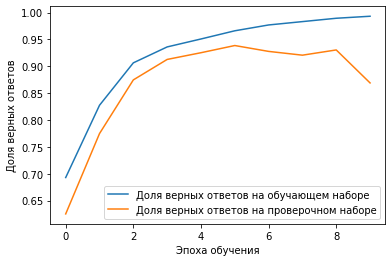

In [ ]:
# график прогрессии обучения нейросети в Matplotlib
plt.plot(history.history['auc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_auc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='best')
plt.show()

In [ ]:
# Дообучаем нейросеть
model.compile(loss='binary_crossentropy', metrics=[AUC(num_thresholds=150)], optimizer=RMSprop(lr=1e-4)) #
history = model.fit(Xtrain, Ytrain, batch_size=96, epochs=50, validation_data=(Xtest, Ytest))


Epoch 1/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0925 - auc_1: 0.9943 - val_loss: 0.4752 - val_auc_1: 0.8800
Epoch 2/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0712 - auc_1: 0.9967 - val_loss: 0.4673 - val_auc_1: 0.8878
Epoch 3/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0479 - auc_1: 0.9989 - val_loss: 0.5518 - val_auc_1: 0.8689
Epoch 4/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0369 - auc_1: 0.9993 - val_loss: 0.6200 - val_auc_1: 0.8606
Epoch 5/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0295 - auc_1: 0.9995 - val_loss: 0.4311 - val_auc_1: 0.9179
Epoch 6/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0237 - auc_1: 0.9999 - val_loss: 0.5004 - val_auc_1: 0.9059
Epoch 7/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0199 - auc_1: 0.9993 - val_loss: 0.5075 - val_auc_1: 0.9064
Epoch 8/50
30/30 [==============================] - 1s 

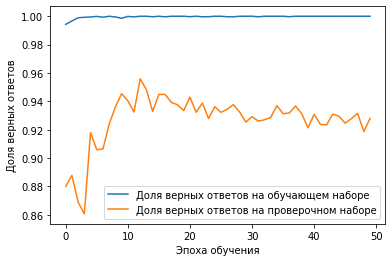

In [ ]:
# график прогрессии обучения нейросети в Matplotlib
plt.plot(history.history['auc_1'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_auc_1'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='best')
plt.show()

**Проверка качества работы нейронной сети**

In [ ]:
Xtest.shape


(715, 128)

In [ ]:
Y_hat = model.predict(Xtest)
Y_hat.shape, Ytest.shape

((715, 1), (715, 1))

In [ ]:
y_coincidence = 0
y_unrecognized = 0
y_contrived = 0
for i, pred in enumerate(Y_hat):
  b = Ytest[i][0]
  a = round(pred[0])
  print(a, b, paragraphs_test[i])
  if a+b>1.5:
    y_coincidence += 1
  elif a+b<0.5:
    y_coincidence += 1
  else:
    if a>0.5:
      y_contrived += 1
    else:
      y_unrecognized += 1

print(f"\nРаспознано: {y_coincidence}; Нераспознано: {y_unrecognized}; Надумано: {y_contrived}")  

1.0 1 ['удобный', 'поиск', '—', 'возможность', 'использования', 'эффективной', 'системы', 'поиска', '(', 'полнотекстовый', 'поиск', ',', 'одновременный', 'поиск', 'в', 'нескольких', 'словарях', ',', 'высокая', 'скорость', 'поиска', ')', '[', '26', ']', '.']
1.0 1 ['синтаксический', 'анализатор', '(', 'жарг.', 'парсер', '←', 'англ.', 'parser', ')', '—', 'это', 'программа', 'или', 'часть', 'программы', ',', 'выполняющая', 'синтаксический', 'анализ', '.']
1.0 1 ['свойство', '—', 'необходимое', 'условие', 'принадлежности', 'классу', '.']
1.0 1 ['парадигма', 'программирования', 'как', 'исходная', 'концептуальная', 'схема', 'постановки', 'проблем', 'и', 'их', 'решения', 'является', 'инструментом', 'грамматического', 'описания', 'фактов', ',', 'событий', ',', 'явлений', 'и', 'процессов', ',', 'возможно', ',', 'не', 'существующих', 'одновременно', ',', 'но', 'интуитивно', 'объединяемых', 'в', 'общее', 'понятие', '.']
1.0 1 ['ветвление', '—', 'однократное', 'выполнение', 'одной', 'из', 'двух', 

ROC-кривая (англ. receiver operating characteristic, рабочая характеристика приёмника) — график, позволяющий оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак (англ. true positive rate, TPR, называемой чувствительностью алгоритма классификации), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак (англ. false positive rate, FPR, величина 1-FPR называется специфичностью алгоритма классификации) при варьировании порога решающего правила.

https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F

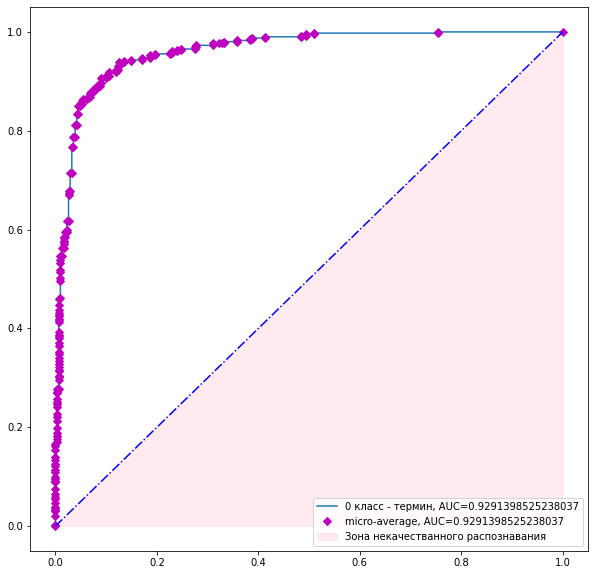

In [ ]:
plt.figure(figsize=(10,10))


num_classes = 1 #узнаем, сколько всего классов
for i in range(num_classes): #проходимся по всем классам
  fpr, tpr, thresholds = roc_curve(Ytest[:, i], Y_hat[:, i]) #получаем roc-кривую для очередного класса
  plt.plot(fpr, tpr, label='{} класс - {}, AUC={}'.format(i, dic_color[i], AUC()(Ytest[:, i], Y_hat[:, i]))) #отрисовываем кривую и подписываем ее площадь

avg_fpr, avg_tpr, thresholds = roc_curve(Ytest.flatten(), Y_hat.flatten()) #получаем micro-average (общую) кривую roc
plt.plot(avg_fpr, avg_tpr, 'mD',label='micro-average, AUC={}'.format(AUC()(Ytest, Y_hat)))#отрисовываем кривую и подписываем ее площадь
plt.plot([0,1], [0,1], 'b-.') #обозначим границу качественной работы нейросети
plt.fill_between([0,1], [0,1], label='Зона некачестванного распознавания', color='pink', alpha=0.3) #обозначим границу некачественной работы нейросети
plt.legend()

## Выборка массивов для следующего шага по извлечению определительных структур во фразах с ожидаемым семантическим статусом

In [ ]:
paragraphs_train_2 = []
tags_train_2 = []
for i, elem in enumerate(semantics_train):
  if elem[0]==1:
    paragraphs_train_2.append(paragraphs_train[i])
    tags_train_2.append(tags_train[i])

print(f'Обучающие массивы (с размерностью {train_yes})',len(paragraphs_train_2), len(tags_train_2))


Обучающие массивы (с размерностью 1543) 1543 1543


In [ ]:
Y_hat
paragraphs_test_2 = []
tags_test_2 = []
for i, elem in enumerate(Y_hat):
  if round(elem[0])>0:
    paragraphs_test_2.append(paragraphs_test[i])
    tags_test_2.append(tags_test[i])

print(f'Тренировочные массивы (с размерностью {test_yes}):',len(paragraphs_test_2), len(tags_test_2))


Тренировочные массивы (с размерностью 405): 374 374


# **Step 2. Segmentation of text**

## Preparing a dataset

Объединим обучающий и тестовый массивы, чтобы воспользоваться общим токенизатором.

In [ ]:
all_paragraphs = paragraphs_train_2 + paragraphs_test_2
all_tags = tags_train_2 + tags_test_2
print(len(all_paragraphs))
print(len(all_tags))

1917
1917


In [ ]:
all_paragraphs_together = [' '.join(sequence) for sequence in all_paragraphs]

In [ ]:
all_paragraphs_together[0]

'декларативное программирование — парадигма программирования , в которой задаётся спецификация решения задачи , то есть описывается , что представляет собой проблема и ожидаемый результат .'

In [ ]:
all_tags_together = [' '.join(tag) for tag in all_tags]

In [ ]:
all_tags_together[0]

'термин термин связка определение определение o расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка o'

In [ ]:
# Токенайзер для текстов приготовлен на предыдущем шаге

# num_words = 15000
# sent_len = max_paragraph_len 
# tokenizer = Tokenizer(num_words, filters=' \t\n', oov_token='<UNK>')

In [ ]:
# tokenizer.fit_on_texts(all_paragraphs_together)

In [ ]:
# реальная длина словаря. Сравниваем со значением num_words
# len(tokenizer.index_word)

14552

In [ ]:
# Токенайзер для категорий определительной структуры ещё не готов

tag_tokenizer = Tokenizer(filters=' ') # colors_count - количество категорий - лучше не указывать, чтобы не потерять категории. Все они автоматически подцедпляются под своими индексами

In [ ]:
tag_tokenizer.fit_on_texts(all_tags_together)

In [ ]:
tag_tokenizer.index_word # Здесь обращаем внимание, что фактическая нумерация индексов смещена на единицу по сравнению с массивом color_dic

{1: 'o',
 2: 'расшифровка',
 3: 'определение',
 4: 'термин',
 5: 'связка',
 6: 'дубль-термин',
 7: 'дубль-определение',
 8: 'дубль-связка',
 9: 'дубль-расшифровка'}

In [ ]:
tag_tokenizer.word_index

{'o': 1,
 'дубль-определение': 7,
 'дубль-расшифровка': 9,
 'дубль-связка': 8,
 'дубль-термин': 6,
 'определение': 3,
 'расшифровка': 2,
 'связка': 5,
 'термин': 4}

In [ ]:
len(tag_tokenizer.index_word) # эта величина равна colors_count

9

In [ ]:
# prepare color dictionary
tag_tokenizer_dic_color = {}
tag_tokenizer_dic_color[1] = color.END
for i in range(2,10):
  tag_tokenizer_dic_color[i] = dic_colored_items[color_dic[tag_tokenizer.index_word[i]]]
tag_tokenizer_dic_color

{1: '\x1b',
 2: '\x1b\x1b',
 3: '\x1b\x1b',
 4: '\x1b\x1b',
 5: '\x1b\x1b',
 6: '\x1b\x1b',
 7: '\x1b\x1b',
 8: '\x1b\x1b',
 9: '\x1b\x1b'}

**Проверка входящих и исходящих массивов на соответствие их размерностей** 

(для выявления факта порчи данных функцией Tokenizer)

In [ ]:
X_2 = tokenizer.texts_to_sequences(all_paragraphs_together)

In [ ]:
Y_2 = tag_tokenizer.texts_to_sequences(all_tags_together)

In [ ]:
len(X_2)==len(Y_2)

True

In [ ]:
# Проверка на согласованность входных и выходных данных
for i, elem in enumerate(X_2):
  if len(Y_2[i]) != len(X_2[i]):
    print('X_2[{}] ='.format(i),X_2[i])
    print('Y_2[{}] ='.format(i),Y_2[i])
    # Если все массивы равны, то здесь  ничего не должно печататься
  else:
    pass
    # print('len(X_2[{}]) ='.format(i),len(Y_2[i]))

**Выравнивание массивов до максимального размера абзаца**

In [ ]:
X_2 = pad_sequences(X_2, sent_len, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [ ]:
X_2.shape

(1917, 128)

In [ ]:
Y_2 = pad_sequences(Y_2, sent_len, value=1, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [ ]:
Y_2.shape

(1917, 128)

In [ ]:
Y_2 = to_categorical(Y_2, colors_count+1)  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533

In [ ]:
Y_2.shape

(1917, 128, 10)

In [ ]:
Y_2 = Y_2[:, :, 1:]  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533
Y_2.shape

(1917, 128, 9)

In [ ]:
print(tokens_to_text(X_2[13], Y_2[13], 0))

 на рисунке ( справа ) показана дракон-схема « развилка » — графический оператор ветвления с двумя ветвями .


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_2, Y_2, train_size=train_yes, shuffle=False) # Не перемешиваем данные и берём целую часть на тренировочную выборку

### Total for training and testing samples we have:

In [ ]:
# Новые размерности уже "только" для массивов с определительными структурами

print('Xtrain.shape=',Xtrain.shape)
print('Xtest.shape=',Xtest.shape)
print('Ytrain.shape=',Ytrain.shape)
print('Ytest.shape=',Ytest.shape)

Xtrain.shape= (1543, 128)
Xtest.shape= (374, 128)
Ytrain.shape= (1543, 128, 9)
Ytest.shape= (374, 128, 9)


In [ ]:
# Пример окраски размеченного текста
print(tokens_to_text(Xtest[0], Ytest[0], max_paragraph_len))

 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких
 словарях , высокая скорость поиска ) [ 26 ] .


## Modelling

In [ ]:
emb_size = 128

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
model_dir = "/content/drive/My Drive/tmp/"

In [ ]:
'''
  callback-функция сохранения на диск лучшей модели в процессе обучения
  запись осуществляется на google-диск
'''
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="val_dice_coef",
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    )
]

### **Linear segmentation neural network**

### **Recurrent neural network GRU**

#### Algorithm: Embedding + Bidirectional(GRU) + GRU , batch_size = 128, activation='softmax'

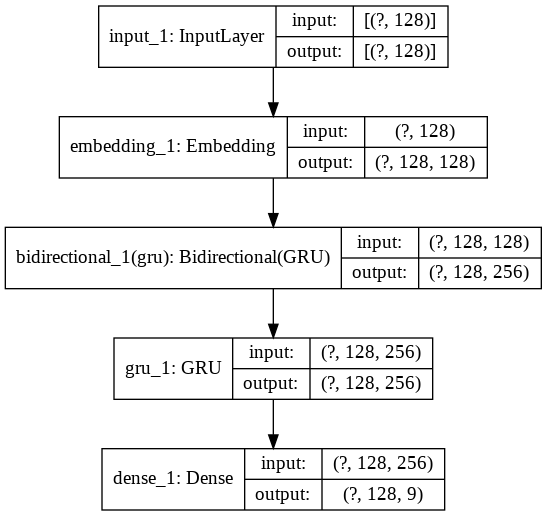

In [ ]:
input = Input((sent_len,))
# input = Input(shape=(None,))
x = Embedding(num_words, emb_size)(input)
x = Bidirectional(GRU(emb_size, return_sequences=True))(x)
x = GRU(emb_size * 2, return_sequences=True)(x)
output = Dense(colors_count, activation='softmax')(x)

modelEGRU = Model(input, output)

modelEGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[dice_coef])
# modelEGRU.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=[dice_coef, AUC(num_thresholds=150)])

plot_model(modelEGRU, show_shapes=True)

In [ ]:
historyEGRU = modelEGRU.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(Xtest, Ytest),  
                    callbacks=callbacks_list,
                    verbose=1)
                    
modelEGRU.save( '/content/drive/My Drive/tmp/modelEGRU_100epochs(gl_extr).h5' )

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 1.0244 - dice_coef: 0.5829
Epoch 00001: val_dice_coef improved from -inf to 0.88494, saving model to /content/drive/My Drive/tmp/weights_epoch_1
13/13 [==============================] - 2s 124ms/step - loss: 1.0244 - dice_coef: 0.5829 - val_loss: 0.3159 - val_dice_coef: 0.8849
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.3620 - dice_coef: 0.8464
Epoch 00002: val_dice_coef did not improve from 0.88494
13/13 [==============================] - 1s 45ms/step - loss: 0.3620 - dice_coef: 0.8464 - val_loss: 0.3018 - val_dice_coef: 0.8691
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3313 - dice_coef: 0.8574
Epoch 00003: val_dice_coef improved from 0.88494 to 0.88614, saving model to /content/drive/My Drive/tmp/weights_epoch_3
13/13 [==============================] - 1s 55ms/step - loss: 0.3311 - dice_coef: 0.8593 - val_loss: 0.2706 - val_dice_coef: 0.8861
Epoch 4/100
13/13 [=

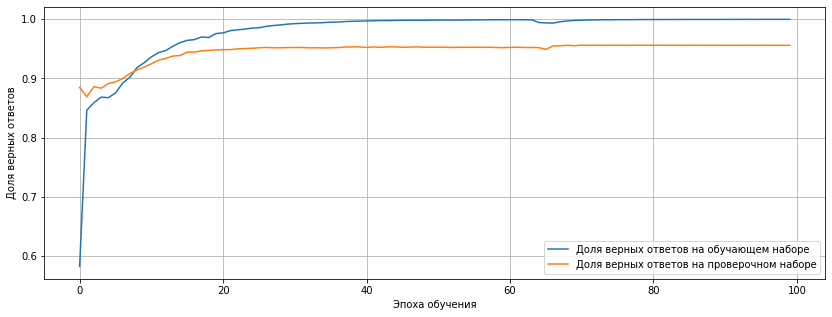

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyEGRU.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyEGRU.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


**Проверка тренировочной выборки (насколько хорошо выучены примеры)**

In [ ]:
YpredEGRU_train = modelEGRU.predict(Xtrain)

In [ ]:
for i, el in enumerate(Xtrain):
  print(f'{i+1}.')
  print(tokens_to_text(el, Ytrain[i]))
  print(tokens_to_text(el, YpredEGRU_train[i]))

1.
 декларативное программирование — парадигма программирования , в которой задаётся спецификация решения задачи , то есть описывается , что представляет собой проблема и ожидаемый результат .
 декларативное программирование — парадигма программирования , в которой задаётся спецификация решения задачи , то есть описывается , что представляет собой проблема и ожидаемый результат .
2.
 императивное программирование — это парадигма программирования ( стиль написания исходного кода компьютерной программы ) , для которой характерно следующее : в исходном коде программы записываются инструкции ( команды ) ; инструкции должны выполняться последовательно ; данные , получаемые при выполнении предыдущих инструкций , могут читаться из памяти последующими инструкциями ; данные , полученные при выполнении инструкции , могут записываться в память .
 императивное программирование — это парадигма программирования ( стиль написания исходного кода компьютерной программы ) , для которой характерно следую

*Чтобы память не забивать, результат 100%-го совпадения предсказаний с разметкой обучающей выборки удалён из текста*

**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [ ]:
YpredEGRU_test = modelEGRU.predict(Xtest)

In [ ]:
# выбираем конкретную фразу из тестовой выборки
i = 2 + 1
print(f'{i}.')
print(tokens_to_text(Xtest[i], Ytest[i]))
print(tokens_to_text(Xtest[i], YpredEGRU_test[i]))

3.
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .


In [ ]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(Xtest):
  print(f'{i+1}.')
  print(tokens_to_text(el, Ytest[i]))
  print(tokens_to_text(el, YpredEGRU_test[i]))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/

1.
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
2.
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
3.
 свойство — необходимое условие принадлежности классу .
 свойство — необходимое условие принадлежности классу .
4.
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее пон

In [ ]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredEGRU_test.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.98      0.99     42766
      расшифровка       0.70      0.76      0.73      1694
      определение       0.73      0.80      0.76      1692
           термин       0.70      0.79      0.74       685
           связка       0.77      0.90      0.83       518
     дубль-термин       0.61      0.34      0.44       234
дубль-определение       0.31      0.15      0.20       167
     дубль-связка       0.36      0.17      0.23        75
дубль-расшифровка       0.00      0.00      0.00        41

         accuracy                           0.96     47872
        macro avg       0.57      0.54      0.55     47872
     weighted avg       0.96      0.96      0.96     47872



### **One-dimensional convolution**

#### Алгоритм: Embedding + Conv1D , batch_size = 16, activation='softmax'
Оборачиваем алгоритм в функцию: **linearSegmentationNet**

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''
def linearSegmentationNet(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 500
      ):
    input = Input((sentence_len,))                                          # Создаем входной слой с размерностью input_shape
    emb = Embedding(num_words, embedding_size)(input)
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv1D(128, 5, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv1D(num_classes,3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(input, x)                                             # Создаем модель с входом 'input' и выходом 'x'

    # Компилируем модель
    # model.compile(optimizer=Adam(lr=1e-3),
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model # Возвращаем сформированную модель

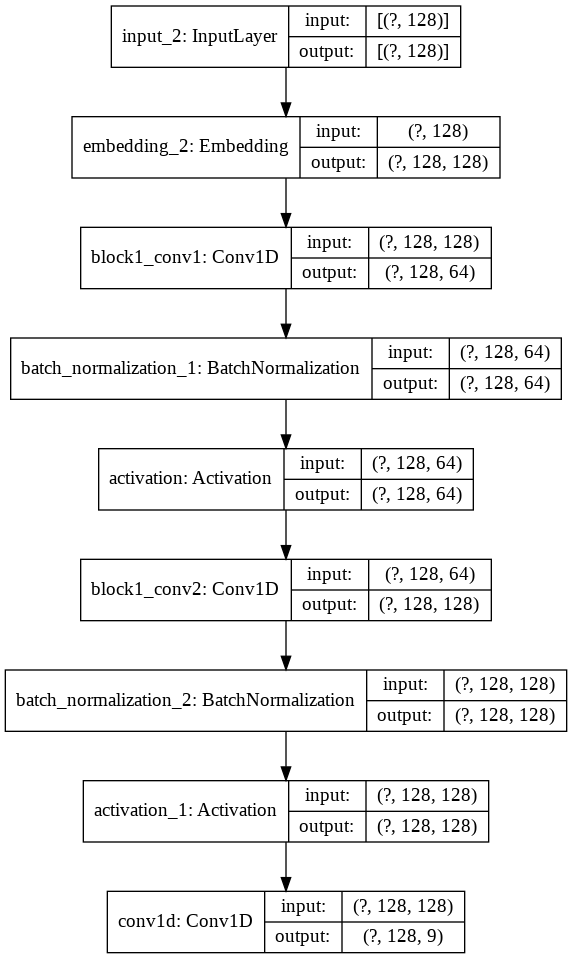

In [ ]:
modelL = linearSegmentationNet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель linearSegmentationNet
plot_model(modelL, show_shapes=True)

In [ ]:
historyL = modelL.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по всем классам

Epoch 1/100
97/97 [==============================] - 1s 13ms/step - loss: 0.3481 - dice_coef: 0.8298 - val_loss: 0.3727 - val_dice_coef: 0.8276
Epoch 2/100
97/97 [==============================] - 1s 11ms/step - loss: 0.1644 - dice_coef: 0.9267 - val_loss: 0.3853 - val_dice_coef: 0.8925
Epoch 3/100
97/97 [==============================] - 1s 11ms/step - loss: 0.1013 - dice_coef: 0.9517 - val_loss: 0.3216 - val_dice_coef: 0.8951
Epoch 4/100
97/97 [==============================] - 1s 11ms/step - loss: 0.0550 - dice_coef: 0.9718 - val_loss: 0.2389 - val_dice_coef: 0.9012
Epoch 5/100
97/97 [==============================] - 1s 11ms/step - loss: 0.0294 - dice_coef: 0.9838 - val_loss: 0.1572 - val_dice_coef: 0.9241
Epoch 6/100
97/97 [==============================] - 1s 11ms/step - loss: 0.0172 - dice_coef: 0.9905 - val_loss: 0.1752 - val_dice_coef: 0.9375
Epoch 7/100
97/97 [==============================] - 1s 11ms/step - loss: 0.0109 - dice_coef: 0.9940 - val_loss: 0.1974 - val_dice_coef:

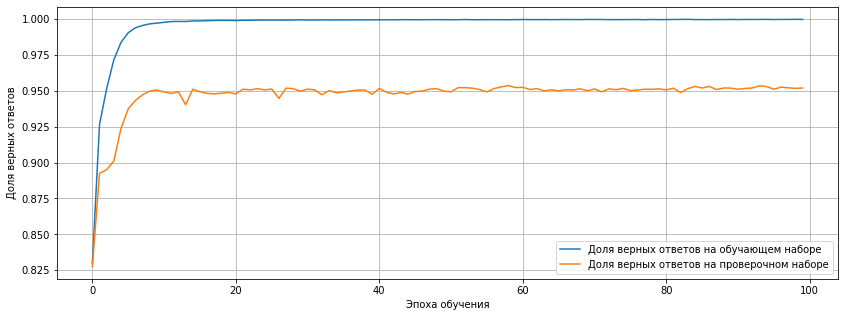

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyL.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyL.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
YpredL = modelL.predict(Xtest)

In [ ]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredL.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.98      0.99     42766
      расшифровка       0.61      0.71      0.66      1694
      определение       0.73      0.71      0.72      1692
           термин       0.75      0.79      0.77       685
           связка       0.82      0.89      0.85       518
     дубль-термин       0.54      0.52      0.53       234
дубль-определение       0.32      0.20      0.24       167
     дубль-связка       0.31      0.28      0.29        75
дубль-расшифровка       0.02      0.02      0.02        41

         accuracy                           0.95     47872
        macro avg       0.56      0.57      0.56     47872
     weighted avg       0.95      0.95      0.95     47872



### **U-net**




In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''

def unet(
      num_classes = 6,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling1D()(block_3_out)                                        # Добавляем слой MaxPooling1D

    # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)        # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv1D(256, 3, padding='same')(x)                             # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv1D(128, 3, padding='same')(x)                             # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x) # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation='softmax', padding='same')(x)  # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x) # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

num_classes= 9
sentence_len= 128
num_words= 15000
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


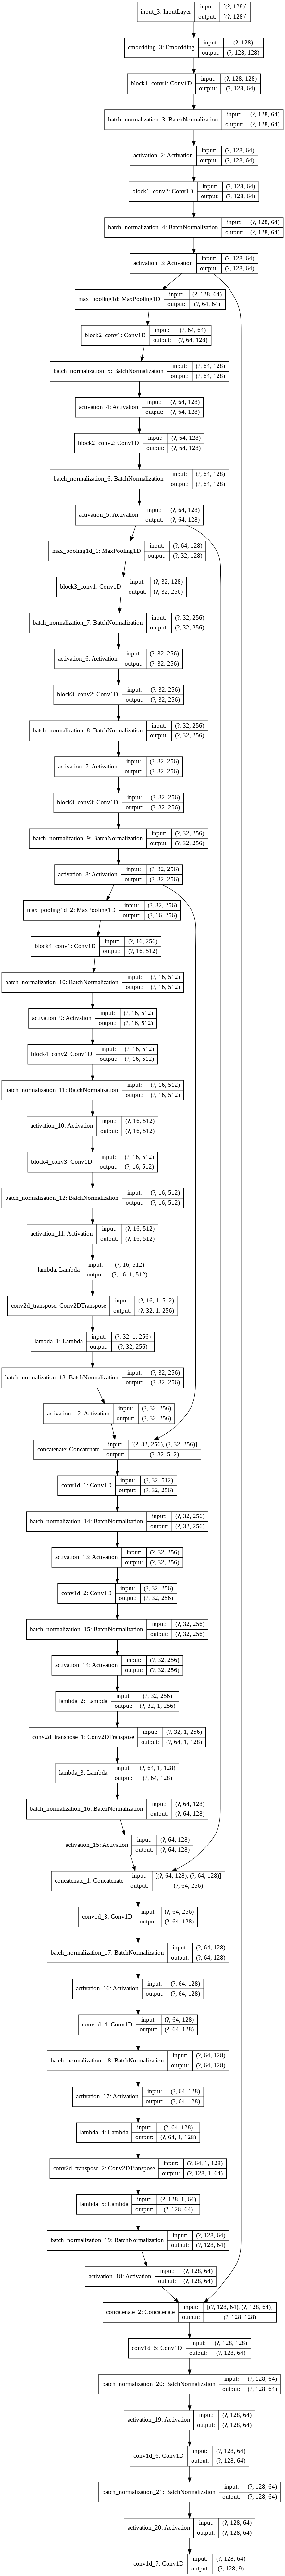

In [ ]:
modelUnet = unet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель unet
plot_model(modelUnet, show_shapes=True)


In [ ]:
historyUnet = modelUnet.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest),  
                    callbacks=callbacks_list,
                    verbose=1) 
                    
modelUnet.save( '/content/drive/My Drive/tmp/modelUnet_100epochs(gl_extr).h5' )

Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 0.5041 - dice_coef: 0.7534
Epoch 00001: val_dice_coef did not improve from 0.95622
97/97 [==============================] - 4s 42ms/step - loss: 0.5041 - dice_coef: 0.7534 - val_loss: 0.5311 - val_dice_coef: 0.8323
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 0.1589 - dice_coef: 0.9219
Epoch 00002: val_dice_coef did not improve from 0.95622
97/97 [==============================] - 3s 30ms/step - loss: 0.1589 - dice_coef: 0.9219 - val_loss: 0.6524 - val_dice_coef: 0.8858
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 0.0932 - dice_coef: 0.9506
Epoch 00003: val_dice_coef did not improve from 0.95622
97/97 [==============================] - 3s 30ms/step - loss: 0.0932 - dice_coef: 0.9506 - val_loss: 0.6743 - val_dice_coef: 0.8914
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.0492 - dice_coef: 0.9708
Epoch 00004: val_dice_coef did not improve from 0.95

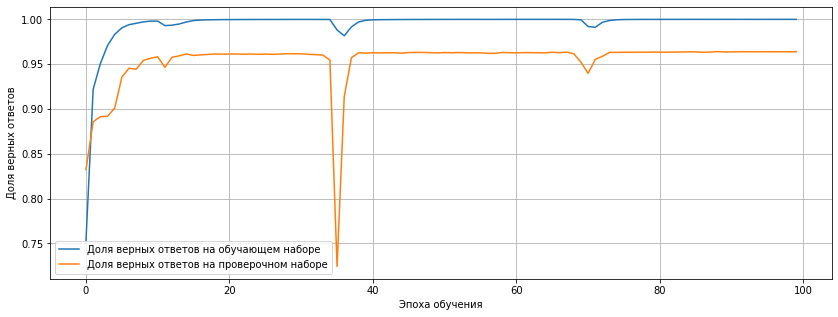

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyUnet.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyUnet.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
YpredUnet = modelUnet.predict(Xtest)

In [ ]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredUnet.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.98      0.99     42766
      расшифровка       0.75      0.87      0.80      1694
      определение       0.80      0.88      0.84      1692
           термин       0.81      0.87      0.84       685
           связка       0.85      0.90      0.88       518
     дубль-термин       0.57      0.39      0.47       234
дубль-определение       0.24      0.22      0.23       167
     дубль-связка       0.30      0.21      0.25        75
дубль-расшифровка       0.00      0.00      0.00        41

         accuracy                           0.97     47872
        macro avg       0.59      0.59      0.59     47872
     weighted avg       0.97      0.97      0.97     47872



**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [ ]:
# выбираем конкретную фразу из тестовой выборки
i = 2
print(f'{i + 1}.')
print(tokens_to_text(Xtest[i], Ytest[i]))
print(tokens_to_text(Xtest[i], YpredUnet[i]))

3.
 свойство — необходимое условие принадлежности классу .
 свойство — необходимое условие принадлежности классу .


In [ ]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(Xtest):
  print(f'{i+1}.')
  print(tokens_to_text(el, Ytest[i]))
  print(tokens_to_text(el, YpredUnet[i]))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/ выше

1.
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
2.
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
3.
 свойство — необходимое условие принадлежности классу .
 свойство — необходимое условие принадлежности классу .
4.
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее пон

### **Simplified U-net**

In [ ]:
def simpleUnet(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(32, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(64, 3, padding='same', name='block2_conv1')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block2_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D
    
    # UP 1
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 2
    # x = Conv1DTranspose(x, 32, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 32 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(32, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(num_classes,3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x)                                            # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

num_classes= 9
sentence_len= 128
num_words= 15000
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


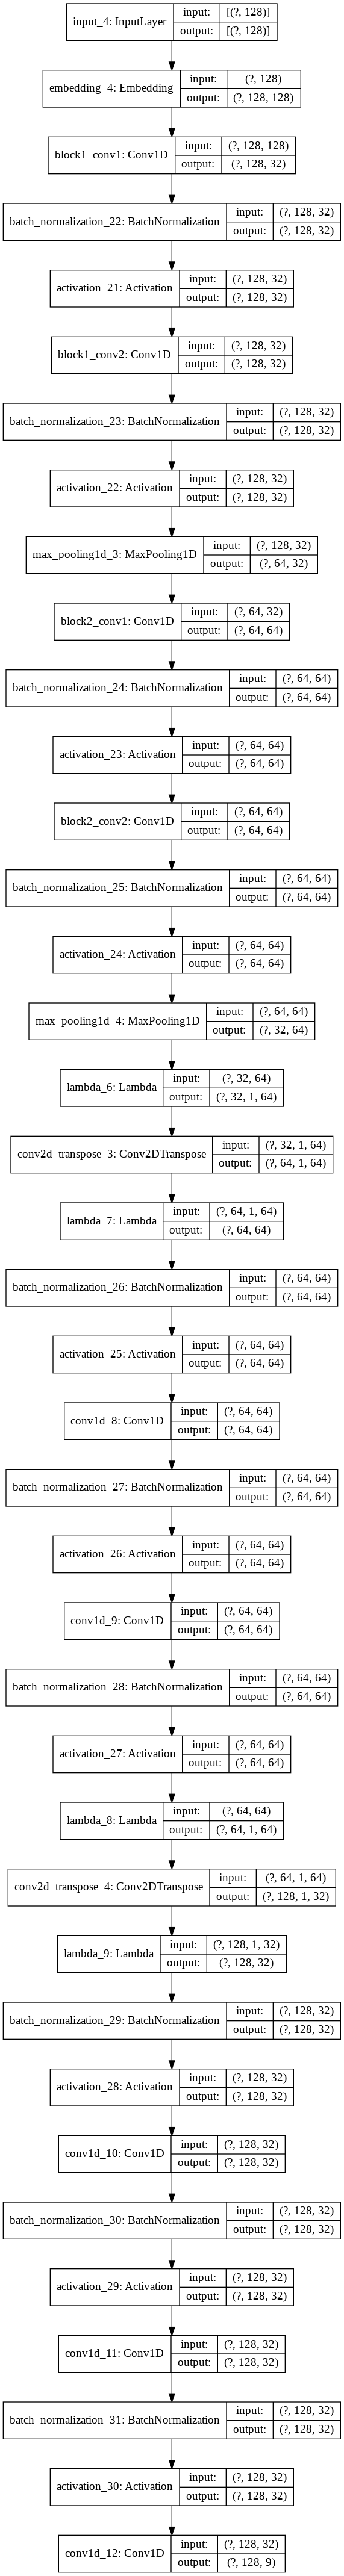

In [ ]:
modelS = simpleUnet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель simpleUnet
plot_model(modelS, show_shapes=True)

In [ ]:
historyS = modelS.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по трем классам

Epoch 1/100
97/97 [==============================] - 3s 27ms/step - loss: 0.5454 - dice_coef: 0.7138 - val_loss: 0.6273 - val_dice_coef: 0.6701
Epoch 2/100
97/97 [==============================] - 2s 21ms/step - loss: 0.2306 - dice_coef: 0.8855 - val_loss: 0.6215 - val_dice_coef: 0.8763
Epoch 3/100
97/97 [==============================] - 2s 22ms/step - loss: 0.1646 - dice_coef: 0.9186 - val_loss: 0.6897 - val_dice_coef: 0.8902
Epoch 4/100
97/97 [==============================] - 2s 21ms/step - loss: 0.1309 - dice_coef: 0.9354 - val_loss: 0.5431 - val_dice_coef: 0.8925
Epoch 5/100
97/97 [==============================] - 2s 21ms/step - loss: 0.1087 - dice_coef: 0.9458 - val_loss: 0.3525 - val_dice_coef: 0.8816
Epoch 6/100
97/97 [==============================] - 2s 21ms/step - loss: 0.0917 - dice_coef: 0.9532 - val_loss: 0.2636 - val_dice_coef: 0.8988
Epoch 7/100
97/97 [==============================] - 2s 21ms/step - loss: 0.0776 - dice_coef: 0.9601 - val_loss: 0.1966 - val_dice_coef:

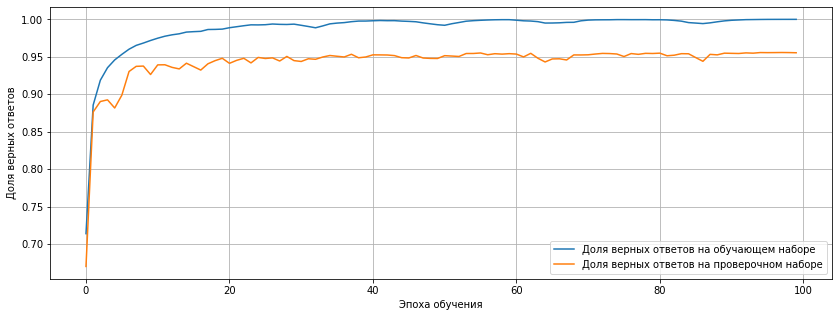

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyS.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyS.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
YpredS = modelS.predict(Xtest)

In [ ]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredS.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.98      0.99     42766
      расшифровка       0.70      0.83      0.76      1694
      определение       0.75      0.84      0.80      1692
           термин       0.75      0.82      0.78       685
           связка       0.86      0.81      0.83       518
     дубль-термин       0.41      0.32      0.36       234
дубль-определение       0.15      0.14      0.15       167
     дубль-связка       0.16      0.16      0.16        75
дубль-расшифровка       0.00      0.00      0.00        41

         accuracy                           0.96     47872
        macro avg       0.53      0.55      0.54     47872
     weighted avg       0.96      0.96      0.96     47872



### **Extended U-net**

In [ ]:
def unetWithMask(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)      # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv1D(64, 1, padding='same')(block_1_out)  # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling1D()(block_1_out) # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)     # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)     # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv1D(128, 1, padding='same')(block_2_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling1D()(block_2_out)                                     # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv1D(256, 1, padding='same')(block_3_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling1D()(block_3_out)                                     # Добавляем слой MaxPooling1D

     # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv1D(512, 1, padding='same')(block_4_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling1D()(block_4_out)                                     # Добавляем слой MaxPooling1D

    # Block 5
    x = Conv1D(512, 3, padding='same', name='block5_conv1')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block5_conv2')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block5_conv3')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling1D()(x)                           # Добавляем слой MaxPooling1D
 
    # UP 1
    # x = Conv1DTranspose(x, 512, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 512 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(512, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv1D(512, 3, padding='same')(x)                          # Добавляем слой Conv1D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same')(x)                          # Добавляем слой Conv1D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv1D(256, 3, padding='same')(x)                          # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)                          # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv1D(128, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv1D(64, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x)                                        # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

num_classes= 9
sentence_len= 128
num_words= 15000
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


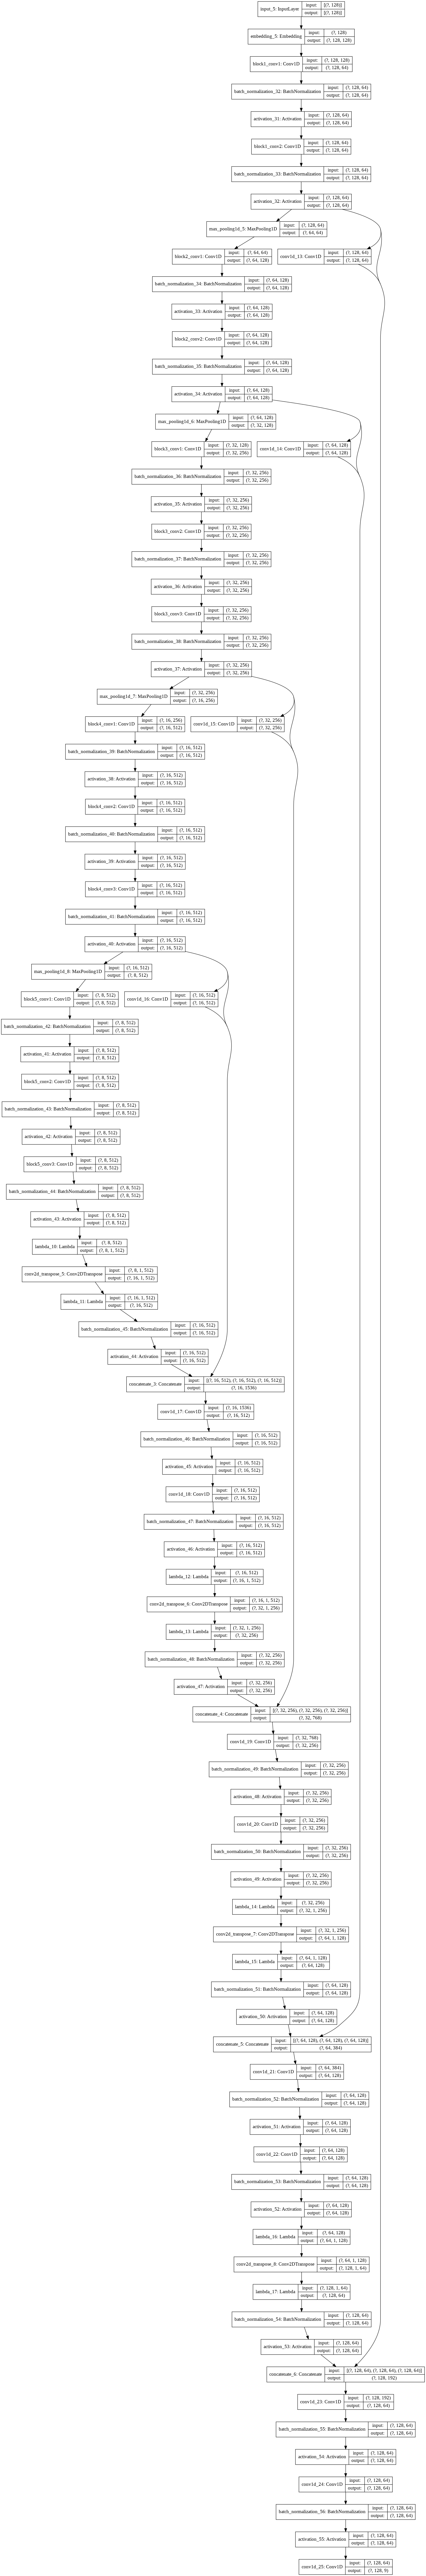

In [ ]:
modelM3 = unetWithMask(colors_count, sent_len, num_words, 'sigmoid', emb_size) # Создаем модель unetWithMask
plot_model(modelM3, show_shapes=True)

In [ ]:
historyM3 = modelM3.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(Xtest, Ytest)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/100
25/25 [==============================] - 2s 92ms/step - loss: 1.6681 - dice_coef: 0.3150 - val_loss: 1.7873 - val_dice_coef: 0.2639
Epoch 2/100
25/25 [==============================] - 1s 47ms/step - loss: 0.6934 - dice_coef: 0.6175 - val_loss: 0.8932 - val_dice_coef: 0.5600
Epoch 3/100
25/25 [==============================] - 1s 48ms/step - loss: 0.3249 - dice_coef: 0.7872 - val_loss: 0.5901 - val_dice_coef: 0.7345
Epoch 4/100
25/25 [==============================] - 1s 48ms/step - loss: 0.2020 - dice_coef: 0.8679 - val_loss: 0.5444 - val_dice_coef: 0.7983
Epoch 5/100
25/25 [==============================] - 1s 48ms/step - loss: 0.1178 - dice_coef: 0.9064 - val_loss: 0.5651 - val_dice_coef: 0.8313
Epoch 6/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0704 - dice_coef: 0.9216 - val_loss: 0.5945 - val_dice_coef: 0.8479
Epoch 7/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0552 - dice_coef: 0.9267 - val_loss: 0.6243 - val_dice_coef:

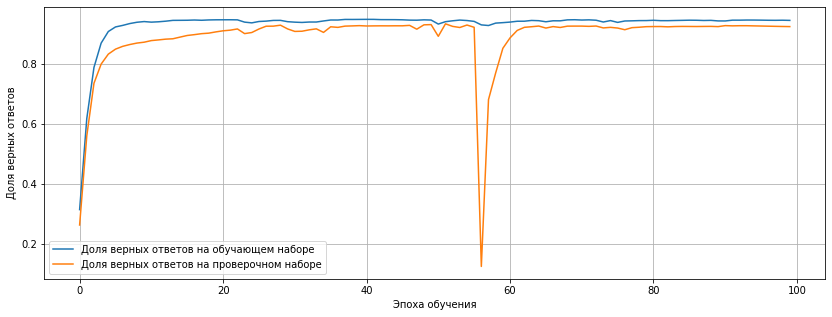

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyM3.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyM3.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
YpredM3 = modelM3.predict(Xtest)

In [ ]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredM3.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.98      0.99     42766
      расшифровка       0.72      0.82      0.77      1694
      определение       0.73      0.88      0.80      1692
           термин       0.78      0.82      0.80       685
           связка       0.87      0.89      0.88       518
     дубль-термин       0.62      0.46      0.53       234
дубль-определение       0.33      0.22      0.26       167
     дубль-связка       0.36      0.23      0.28        75
дубль-расшифровка       0.17      0.05      0.08        41

         accuracy                           0.96     47872
        macro avg       0.62      0.59      0.60     47872
     weighted avg       0.96      0.96      0.96     47872

